# TMA Capacitor Bank discharge vs. current draw profiles

# SITCOM-1224

**title**: TMA (Telescope Mount Assembly) Capacitor Bank discharge vs. current draw profiles

**Description**: Continue in the analysis started in SITCOM-1146 (https://jira.lsstcorp.org/browse/SITCOM-1146). 
This ticket for looking at the relationship between the current draw (rather than power supply voltage) 
and also how much power was in the banks prior to a large drop. This was explored a bit in SITCOM-1146, but could be expanded.

**Author**: Laura Toribio San Cipriano

2024-03-13

### Setup

In [15]:
%matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from lsst_efd_client import EfdClient, resample
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState

from astropy.time import Time, TimeDelta
from astropy.table import Table
from scipy.interpolate import UnivariateSpline

In [3]:
client = EfdClient('usdf_efd')

In [4]:
tma_power_topic = 'lsst.sal.MTMount.mainPowerSupply'
tma_el_topic = 'lsst.sal.MTMount.elevation'
tma_az_topic = 'lsst.sal.MTMount.azimuth'

### Get Data

In [5]:
obs_days = [20240301]#, 20240302, 20240303, 20240304, 20240305]

In [6]:
def get_events(dayObs):
    """
    Identify slew events for a given dayObs
    """
    eventMaker = TMAEventMaker()
    events = eventMaker.getEvents(dayObs)
    
    # Get lists of slew and track events
    slews = [e for e in events if e.type == TMAState.SLEWING]
    tracks = [e for e in events if e.type == TMAState.TRACKING]
    print(f"{dayObs}: Found {len(slews)} slews and {len(tracks)} tracks")
    return slews

In [7]:
def get_acc_jerk(time, velocity):
    """
    From velocity data, calculate acceleration and jerk
    """
    try:
       smoothing_factor=0.2
       kernel_size = 5
       kernel = np.ones(kernel_size) / kernel_size
    
       VelSpline = UnivariateSpline(time, velocity, s=0)
       smoothedVel = np.convolve(VelSpline(time), kernel, mode='same')
       VelSpline = UnivariateSpline(time, smoothedVel, s=smoothing_factor)
    
       AccSpline = VelSpline.derivative(n=1)
       smoothedAcc = np.convolve(AccSpline(time), kernel, mode='same')
       AccSpline = UnivariateSpline(time, smoothedAcc, s=smoothing_factor)
   
       JerkSpline = AccSpline.derivative(n=1) 

       return VelSpline(time), AccSpline(time), JerkSpline(time)
    except:
        return False, False, False

In [8]:
async def data_per_slew(i, slew, debug=False):
    """
    get TMA velocity data, power data for a given slew and e currren draw

    Calculate maximum velocity, acceleration and jerk values and minimum power draw
    """
    data = [i, slew.dayObs, slew.duration, slew.begin, slew.end]

    power_df = await client.select_time_series(tma_power_topic, '*', slew.begin, slew.end)
    data.append(np.min(power_df.powerSupplyVoltage))
    data.append(np.max(power_df.powerSupplyCurrent))
    
    az = await client.select_time_series(tma_az_topic, ['*'], slew.begin, slew.end)
    el = await client.select_time_series(tma_el_topic, ['*'], slew.begin, slew.end)
   
    AzBegin = az.actualPosition.iloc[0]
    AzEnd   = az.actualPosition.iloc[-1]
    ElBegin = el.actualPosition.iloc[0]
    ElEnd   = el.actualPosition.iloc[-1]
    
    AzVel, AzAcc, AzJerk = get_acc_jerk(az.timestamp, az.actualVelocity)
    ElVel, ElAcc, ElJerk = get_acc_jerk(el.timestamp, el.actualVelocity)

    for var in [AzVel, AzAcc, AzJerk, ElVel, ElAcc, ElJerk, AzBegin, AzEnd, ElBegin, ElEnd]:
        data.append(np.max(np.abs(var)))
    if debug:
        return az, el, power_df, data
    else:
        return data

In [9]:
Data = []
failed = []
data_names = ['slew_id','dayobs','duration','begin','end','min_power','max_current','az_max_vel','az_max_acc','az_max_jerk','el_max_vel','el_max_acc','el_max_jerk', 'az_pos_begin', 'az_pos_end', 'el_pos_begin', 'el_pos_end'] #, 'dis_slew'
for dayObs in obs_days:
    try:
        slews = get_events(dayObs)
    except:
        print(dayObs)
    for i, slew in enumerate(slews):
        try:
            d = await data_per_slew(i, slew)
            Data.append(d)
        except Exception as e:
            failed.append(i)
            #print(i, e)
df = pd.DataFrame(np.vstack(Data),columns=data_names)


20240301: Found 375 slews and 350 tracks


In [10]:
#Remove extreme outliers
df = df[(df.el_max_jerk < 100)&(df.duration<3000)]

### Analysis

#### Relationship of max power supply Current draw and distance of slew

In [12]:
def plot_spc_vs_dist(df_, title_date, name):
    fig, (ax1) = plt.subplots(figsize=(8, 4))

    # Scatter plot of slew distances vs. min_power
    ax1.plot((df_.az_pos_begin - df_.az_pos_end), df_.max_current, 'x', color='C0', label='az')
    ax1.plot((df_.el_pos_begin - df_.el_pos_end), df_.max_current, 'x',  alpha=0.7, color='C1', label='el')
    #ax1.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax1.legend()
    ax1.set_xlabel('Slew distances (az/el)')
    ax1.set_ylabel('max supplyPowerCurrent (V)')
    ax1.set_title(f'Max. TMA current vs. distance of slew for {title_date}')

    fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 4))
    # Histogram of absolute values of position differences
    ax2.hist(df_.az_pos_begin - df_.az_pos_end, color='C0', label='az')
    ax2.hist(df_.el_pos_begin - df_.el_pos_end, color='C1', alpha=0.7, label='el')
    ax2.legend()
    ax2.set_xlabel('Slew distances (az/el)')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Slew distance Histogram for {title_date}')
    
    # Histogram of min_power
    ax3.hist(df_.max_current, bins=20, color='C0', edgecolor='black', alpha=0.5)
    #ax3.axvline(575, ls='--', c='k', label='voltage drop limit')
    ax3.legend()
    ax3.set_xlabel('max supplyPowerCurrent (V)')
    ax3.set_ylabel('Frequency')
    ax3.set_title(f'Max. TMA current histogram for {title_date}')
    
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{name}.png')

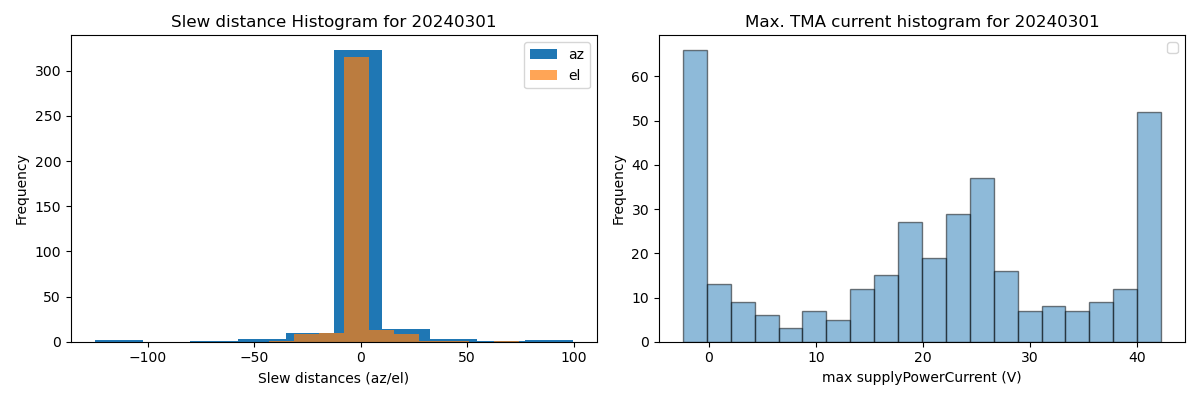

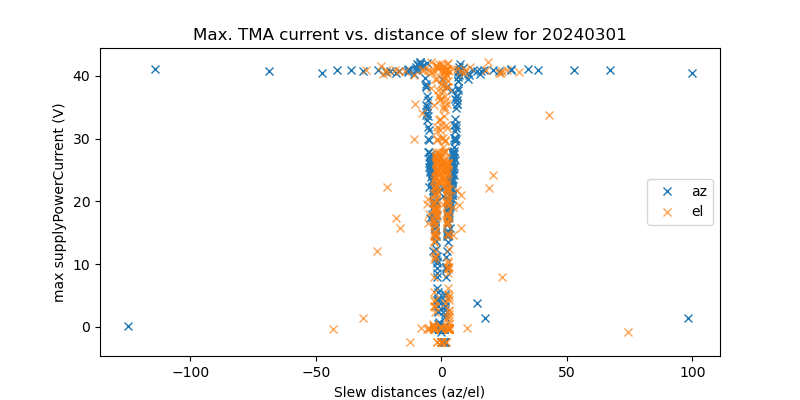

In [16]:
for dayObs in np.unique(df.dayobs):
    df_ = df[df.dayobs == dayObs]
    plot_spc_vs_dist(df_, dayObs,'tma_perf_mar_2024')

#### Look at Azimuth acceleration vs. power supply current

In [17]:
def plots_spc_vs_az(df_, title_date,name):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(12, 4))

    ax1.plot(df_.az_max_vel, df_.max_current,'x',label='azVel')
    #ax1.plot(df_.el_max_vel, df_.min_power,'x', label='elVel')
    #ax1.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax1.legend()
    #ax1.set_xlim(-1,12)
    ax1.set_xlabel('max Velocity (m/s)')
    ax1.set_ylabel('max supplyPowerCurrent (V)')

    ax2.plot(df_.az_max_acc, df_.max_current,'x',label='azAcc')
    #ax2.plot(df_.el_max_acc, df_.min_power,'x',label='elAcc')
    #ax2.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax2.legend()
    #ax2.set_xlim(-1,25)
    ax2.set_xlabel('max Acceleration $(m/s^{2})$')
    #ax2.set_ylabel('min supplyPowerVoltage (V)')
               
    ax3.plot((df_.az_pos_begin - df_.az_pos_end), df_.max_current,'x',label='azSlewDis')
    #ax3.plot(df_.el_max_jerk, df_.min_power,'x', label='elJerk')
    #ax3.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax3.legend()
    #ax3.set_xlim(-100,800)
    ax3.set_xlabel('Slew distances')
    #ax3.set_ylabel('min supplyPowerVoltage (V)')
               
    fig.suptitle(f'Max. TMA current vs. TMA Performance for {title_date}')
    fig.tight_layout()
    plt.savefig(f'{name}.png')

In [ ]:
def plots_az(df_, title_date,name):
    df_ = df_[(df_.min_power<575)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12, 4))
     
    ax1.plot((df_.az_pos_begin - df_.az_pos_end), df_.max_current,'x',label='azSlewDis for Min. Power < 575V')
    #ax1.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax1.legend()
    ax1.set_xlabel('Slew distances')
    ax1.set_ylabel('min supplyPowerVoltage (V)')

    
    bins = np.linspace(-150, +150, 25)
    ax2.hist(df_.az_pos_begin - df_.az_pos_end, alpha=0.5, bins=bins, color='C0')
    ax2.hist(df_.az_pos_begin - df_.az_pos_end, alpha=0.7, bins=bins, label='Min. Power < 575V')  
    ax2.set_xlabel('Slew distances')
    ax2.set_ylabel('Azimuth')

    
    fig.suptitle(f'Min. TMA voltage vs. TMA Performance for {title_date} for min_power<575')
    fig.tight_layout()
    plt.savefig(f'{name}.png')